In [1]:
import sys
is_kaggle_notebook = "kaggle_web_client" in sys.modules
if is_kaggle_notebook:
    !pip uninstall timm -y

In [2]:
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
sys.path.append('/kaggle/input/einops/einops-master')


In [3]:
import gc
import os
import random
import shutil
import sys
import warnings
from glob import glob
import re

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from einops import rearrange
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy import ndimage

warnings.simplefilter("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
is_kaggle_notebook = "kaggle_web_client" in sys.modules

## config

In [58]:
class CFG:

    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    start = 23
    stop = 38
    input_dirs = f"/kaggle/input/vesuvius-challenge-ink-detection/test/"
    stack_dir = f"/kaggle/working/dataset_inference/"
    save_dir = f"/kaggle/working/dataset_inference/nonflatten/"
    test_dataset_path = f"/kaggle/working/dataset_inference/nonflatten/{start}-{stop}/"

    exp_name = "model14"
    TH = 0.45
    fold = 5


    # ============== model cfg =============
    in_chans = stop-start+1
    crop_depth = 6
    random_shift = 1
    layer_shift = [0, 2, 4, 6, 8]
    # ============== pred target =============
    
    target_size = 1
    TTA = is_kaggle_notebook
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size // 4

    valid_batch_size = 8  # 32
    use_amp = True

    # ============== fixed =============
    num_workers = 4

    # ============== augmentation =============
    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


## dataset preprocess

In [5]:
GAUSSIAN_BLUR_TOPOGRAPHIC_MAP = False


def split_label_mask_inference(input_dir, dataset_dir, fragment_i):
    shutil.copy(f"{input_dir}/mask.png", dataset_dir + f"mask_{fragment_i}.png")


def split_stack_image(input_dir, dataset_dir, split=1):
    fragment_i = input_dir.split("/")[-1]
    image_height = cv2.imread(f"{input_dir}/surface_volume/01.tif", -1).shape[0]
    split_height = image_height // split

    for split_i in range(split):
        image_stack = None
        images = []

        surfaces_path = sorted(glob(f"{input_dir}/surface_volume/*.tif"))
        save_npy_path = dataset_dir + f"image_stack_{fragment_i}_{split_i}.npy"
        if os.path.exists(save_npy_path):
            continue

        for surface_path in tqdm(surfaces_path):
            image = cv2.imread(surface_path, -1)
            if split_i < split - 1:
                image = image[split_i * split_height: (split_i + 1) * split_height, :]
            else:
                image = image[split_i * split_height: image_height, :]
            images.append(image)
            del image
        image_stack = np.stack(images)

        with open(save_npy_path, "wb") as f:
            np.save(f, image_stack, allow_pickle=True)


def extract_nonflatten_layers(input_stack_path, output_stack_path, start, stop):
    if os.path.exists(output_stack_path):
        return

    stack = np.load(open(input_stack_path, "rb"))
    stack = stack[start: stop + 1, :, :]

    with open(output_stack_path, "wb") as f:
        np.save(f, stack, allow_pickle=True)


def concat_npy(save_dir, fragment_i):
    output_path = f"{save_dir}/{fragment_i}.npy"
    if os.path.exists(output_path):
        return

    npy_list = []
    for npy in sorted(glob(f"{save_dir}/{fragment_i}_*.npy")):
        npy_list.append(np.load(open(npy, 'rb')))

    result = np.concatenate(npy_list, axis=1)

    with open(output_path, 'wb') as f:
        np.save(f, result, allow_pickle=True)


In [6]:
if is_kaggle_notebook:
    split=3
else:
    split=1


In [7]:
for input_dir in glob(f"{CFG.input_dirs}/*"):
    print(input_dir)
    image_stack_dir = f"{CFG.stack_dir}/nonflatten/"
    extract_save_dir = f"{image_stack_dir}/{CFG.start}-{CFG.stop}/"
    fragment_i = input_dir.split("/")[-1]
    
    os.makedirs(CFG.stack_dir, exist_ok=True)
    os.makedirs(image_stack_dir, exist_ok=True)
    os.makedirs(extract_save_dir, exist_ok=True)

    split_label_mask_inference(input_dir, CFG.stack_dir, fragment_i)
    split_stack_image(input_dir, CFG.stack_dir, split)

    for split_i in range(split):
        input_stack_path = f"{CFG.stack_dir}/image_stack_{fragment_i}_{split_i}.npy"
        output_stack_path = f"{extract_save_dir}/{fragment_i}_{split_i}.npy"
        extract_nonflatten_layers(input_stack_path, output_stack_path, CFG.start, CFG.stop)

    concat_npy(extract_save_dir, fragment_i)
    
    

/kaggle/input/vesuvius-challenge-ink-detection/test/a
/kaggle/input/vesuvius-challenge-ink-detection/test/b


In [8]:
def create_topomap(image_stack, x, y, range, z_buffer):
    clipped_stack = image_stack[:, x: x + range, y: y + range]
    clipped_stack = clipped_stack / 65535
    clipped_stack = np.flip(clipped_stack, axis=0)
    gauss_stack = gaussian_filter(clipped_stack, sigma=1)
    gauss_stack = ndimage.sobel(gauss_stack, axis=0)
    gauss_stack = gaussian_filter(gauss_stack, sigma=1)

    filtered_stack = np.where(gauss_stack >= 0.5, 1, 0)  # type: ignore
    topographic_map = np.argmax(filtered_stack, axis=0)

    topographic_map = 64 - np.where(topographic_map == 0, 64, topographic_map).astype("uint8")
    topographic_map = cv2.medianBlur(topographic_map, 15)

    is_idx = np.indices(clipped_stack.shape)
    flattened_stack = clipped_stack[(is_idx[0] + topographic_map - z_buffer) % clipped_stack.shape[0], is_idx[1], is_idx[2], ]
    flattened_stack = (np.flip(flattened_stack, axis=0) * 65536).astype("uint16")

    return topographic_map


def create_whole_topomap(image_stack_path, output_topography_path):
    if os.path.exists(output_topography_path):
        return
    
    image_stack = np.load(open(image_stack_path, "rb"))

    _, image_stack_x, image_stack_y = image_stack.shape
    output_topography = np.zeros(image_stack.shape[1:])
    for x in range(0, image_stack_x, 250):
        for y in range(0, image_stack_y, 250):
            topographic_map = create_topomap(image_stack, x, y, 250, 5)
            output_topography[x: x + 250, y: y + 250] = topographic_map

    cv2.imwrite(output_topography_path, output_topography)

def concat_topo(save_dir, fragment_i):
    topo_list = []
    for topo in sorted(glob(f"{save_dir}/topography_{fragment_i}_*.png")):
        topo_list.append(cv2.imread(topo, -1))
    result = np.concatenate(topo_list, axis=0)
    output_topo_fname = f"{save_dir}/topography_{fragment_i}.png"
    print(output_topo_fname)
    cv2.imwrite(output_topo_fname, result)

In [9]:
for image_stack_path in glob(f"{CFG.stack_dir}/image_stack*"):
    fragment_i = image_stack_path.split("/")[-1].split("_")[2]
    split_i = image_stack_path.split("/")[-1].split("_")[3].split(".")[0]
    output_topography_path = os.path.join(CFG.stack_dir + f"topography_{fragment_i}_{split_i}.png")
    create_whole_topomap(image_stack_path, output_topography_path)


fragment_list = [i.split("_")[-1].split(".")[0] for i in glob(f"{CFG.stack_dir}/mask*")]

for fragment_i in fragment_list:
    concat_topo(CFG.stack_dir , fragment_i)
    topography = cv2.imread(f"{CFG.stack_dir}/topography_{fragment_i}.png", 0)
    new_mask=np.logical_and(45>topography, topography>20).astype("uint8")*255
    cv2.imwrite(f"{CFG.stack_dir}/mask_{fragment_i}.png", new_mask)

/kaggle/working/dataset_inference//topography_a.png
/kaggle/working/dataset_inference//topography_b.png


In [10]:
if is_kaggle_notebook:
    for path in glob(f"{CFG.stack_dir}/**/*.*", recursive=True):
        if re.search(r"_\d", path):
            os.remove(path)

## helper

In [11]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## dataset

In [12]:
def preprocess(image):
    return image


In [13]:
def read_image(fragment_id):
    image_stack = np.load(open(f"{CFG.test_dataset_path}/{fragment_id}.npy", 'rb'))

    pad0 = (CFG.tile_size - image_stack.shape[1] % CFG.tile_size)
    pad1 = (CFG.tile_size - image_stack.shape[2] % CFG.tile_size)

    image_stack = np.pad(image_stack, [(0, 0), (0, pad0), (0, pad1)], constant_values=0)
    image_stack = image_stack.transpose((1, 2, 0))
    image_stack = preprocess(image_stack)

    return image_stack

def get_transforms(data, cfg):
    aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image

def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))

    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size

            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    # xyxys = np.stack(xyxys)

    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))

    test_loader = DataLoader(test_dataset,
                             batch_size=CFG.valid_batch_size,
                             shuffle=False,
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # return test_images_list
    return test_loader, xyxys


uint16
(2816, 6400, 16)
65535


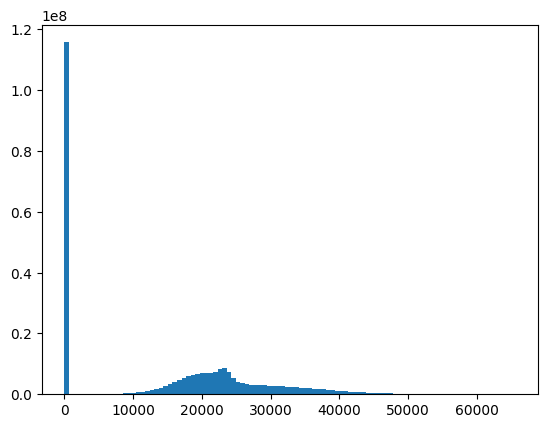

In [14]:
image = read_image("a")
print(image.dtype)
print(image.shape)
print(image.max())
plt.hist(image.flatten(), bins=100);


torch.Size([8, 16, 256, 256])


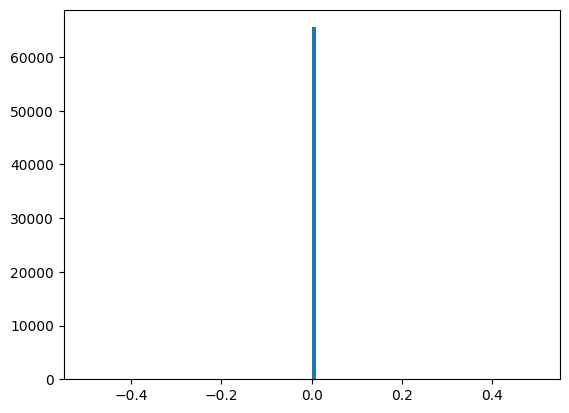

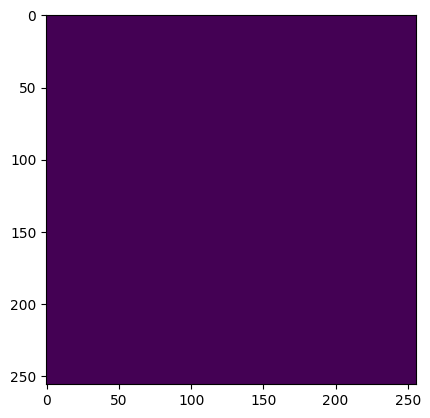

In [15]:
for i, image in enumerate((make_test_dataset("a")[0])):
    if i != 30:
        continue
    print(image.shape)
    plt.figure()
    plt.hist(image[0, 0, :, :].flatten(), bins=100)
    plt.figure()
    plt.imshow(image[0, 0, :, :])
    break


## model

In [16]:

class UnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=False, in_chans=CFG.crop_depth)

        self.decoder1 = UnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=False, in_chans=decoder1_dim[-1])

        self.decoder2 = UnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(CFG.random_shift, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            # e = F.avg_pool2d(e, kernel_size=4, stride=4)
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


In [27]:
def TTA(x: torch.Tensor, model: nn.Module):
    if CFG.TTA:
        shape = x.shape
        x = [x, *[torch.rot90(x, k=i, dims=(-2, -1)) for i in range(1, 4)]]
        x = torch.cat(x, dim=0)
        x = model(x)
        x = torch.sigmoid(x)
        x = x.reshape(4, shape[0], *shape[2:])
        x = [torch.rot90(x[i], k=-i, dims=(-2, -1)) for i in range(4)]
        x = torch.stack(x, dim=0)
        return x.mean(0)
    else:
        x = model(x)
        x = torch.sigmoid(x)
        return x


In [18]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList()
        for fold in range(CFG.fold):
            _model = Net()

            if os.path.exists(f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'):
                model_path = f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
            else:
                model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
            print(model_path)
            state = torch.load(model_path)['model']
            _model.load_state_dict(state)
            _model.eval()

            self.model.append(_model)
    
    def forward(self,x):
        output=[]
        for m in self.model:
            output.append(m(x)[0])
        output=torch.stack(output,dim=0).mean(0)
        return output

In [19]:
num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

fragment_ids = sorted(os.listdir(CFG.input_dirs))
model = EnsembleModel()
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()


./model4/model4_fold0.pth
./model4/model4_fold1.pth
./model4/model4_fold2.pth
./model4/model4_fold3.pth
./model4/model4_fold4.pth


## main

100%|██████████| 498/498 [05:04<00:00,  1.64it/s]


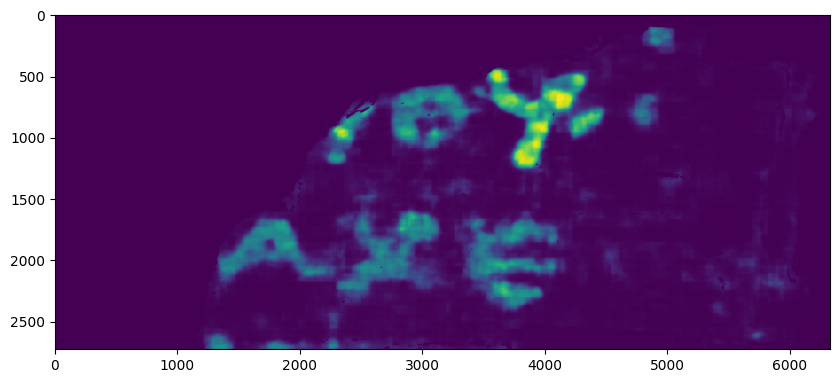

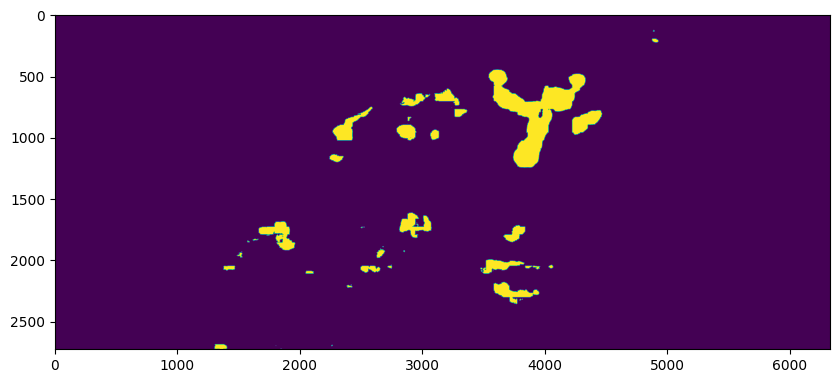

In [26]:
results = []
for fragment_id in fragment_ids:

    test_loader, xyxys = make_test_dataset(fragment_id)

    binary_mask = cv2.imread(CFG.stack_dir + f"/mask_{fragment_id}.png", 0)
    binary_mask = (binary_mask / 255).astype(int)

    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.cuda()
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = TTA(images,model).cpu().numpy()

        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].reshape(mask_pred[y1:y2, x1:x2].shape)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    mask_pred /= mask_count
    del test_loader

    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]

    mask_pred *= binary_mask
    mask_pred_thresh = (mask_pred >= CFG.TH).astype(int)
    
    plt.figure(figsize=(10,10))
    plt.imshow(mask_pred)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(mask_pred_thresh)
    plt.show()

    inklabels_rle = rle(mask_pred_thresh)

    results.append((fragment_id, inklabels_rle))


    gc.collect()
    torch.cuda.empty_cache()
    break

## submission

In [15]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
sample_sub = pd.read_csv("/kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv")
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
if is_kaggle_notebook:
    sample_sub.to_csv("submission.csv", index=False)
sample_sub


,Id,Predicted
0,a,625222 6 631549 13 631568 12 637875 38 644197 ...
1,b,1282 190 1736 56 1797 8 1808 71 7611 192 8064 ...
